# Methods and Results 

In [4]:
# Required packages and versions
# install.packages("janitor")
# install.packages("cowplot")
# install.packages("GGally")

In [5]:
library(tidyverse)
library(janitor)
library(repr)
library(tidymodels)
library(cowplot)
library(GGally)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.4     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘janitor’


The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test


── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::fil

## Preliminary Exploratory Data Analysis

### 1. Load the dataset 


Source: https://www.kaggle.com/datasets/risakashiwabara/jpmean-and-standard-deviation-of-height-and-weight/

To answer this question we will analyze a data set of Japanese boys' heights and weights. This data, `man.csv` was downloaded from [Kaggle](https://www.kaggle.com/datasets/risakashiwabara/jpmean-and-standard-deviation-of-height-and-weight/)(same as source). Each row in the data set represents an observation (i.e. a Japanese boy). 
The columns in the data set `man.csv` represents: 
- `year` - The age of the individual (yrs), which we chose as the **response variable** that is continuous.
- `category` - The region the individual is from
- `height_average` - The average height of the boys with the same age in this region (cm)
- `height_standard deviation` - The standard deviation of the height of the boys with the same age in this region (cm)
- `body weight _average` - The average weight of the boys with the same age in this region (kg)
- `body weight _standard deviation` - The standard deviation of the weight of the boys with the same age in this region (kg)

In [6]:
man_data <- read_csv("https://raw.githubusercontent.com/Ekenny02/dsci-100-project/main/man.csv")

Rows: 624 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): category
dbl (5): year, height_average, height_standard deviation, body weight _avera...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


#### Table 1:  *Man Dataset - untidy*
Here we take a look at the original data set `man_data` (**Table 1**), because there are too many observation, we use `head(man_data)` to get a sens of what the data set looks like. The first 6 rows of the original data set `man_data` is shown below.

In [7]:
head(man_data)

year,category,height_average,height_standard deviation,body weight _average,body weight _standard deviation
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
5,national,111.0,4.87,19.3,2.79
5,Hokkaido,111.3,4.81,19.3,2.83
5,Aomori,111.8,4.87,19.9,2.78
5,Iwate,111.0,5.08,19.6,3.02
5,Miyagi,111.3,4.90,19.7,3.04
5,Akita,112.3,5.08,19.9,3.16


From the original data set table above, we noticed a few **problems**, which we will address in the **data cleaning process**: 
-  We notice that some of the column names are not very tidy because some contain spaces between words. 
-  In the `category` column, representing the region of each observation, we have identified a region labeled **"national"** This category is the average of the values for all regions in the `category` column.
-  The variable name is not informative, for example, `category` actually means the region, and `year` actually means the age.

### 2. Data wrangling and cleaning 


1. To clean the name, we will clean the column names using `clean_names` to make them consist of only lowercase letters and underscores.
2. Because **"national"** is the average of the values(e.g., average heights, average weights) for all regions in the `category` column. We will remove all observations with "national" in the `category` column. 
3. To make the variable names informative, we will rename the columns (variables) `year` to `age` and `category` to `region` to align with our analysis and ensure consistency.

The above steps have made sure the `clean_man_data` is currently in a tidy format, as represented by **Table 2**.

In [8]:
# clean the dataset accordingly
clean_man_data <- man_data |>
        clean_names() |>
        filter(category != "national") |>
        rename("age" = "year",
               "region" = "category")

#### Table 2: *Cleaned Man Datset*
Here we take a look at the cleaned data set `clean_man_data`, because there are too many observation, we use `head(clean_man_data)` to get a sens of what the data set looks like
The first 6 rows of the original data set `clean_man_data` is shown below.

In [9]:
head(clean_man_data)

age,region,height_average,height_standard_deviation,body_weight_average,body_weight_standard_deviation
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
5,Hokkaido,111.3,4.81,19.3,2.83
5,Aomori,111.8,4.87,19.9,2.78
5,Iwate,111.0,5.08,19.6,3.02
5,Miyagi,111.3,4.90,19.7,3.04
5,Akita,112.3,5.08,19.9,3.16
5,Yamagata,111.5,4.46,19.5,3.05


### 3. Initial Split and Training Data Summary Tables


1. Because we want to predict the age of the given boys, we first create a initial split of the data `man_split` and split it to training data `man_train` and testing data `man_test`. Specifically, we set the `strata` to be our target variable `age`, the proportion of training data is `0.75`

In [10]:
set.seed(9999) # set.seed to make sure it is reproducible 
# split the data into training and testing.
man_split <- initial_split(clean_man_data, prop = 0.75, starta = age)
man_train <- training(man_split)
man_test <- testing(man_split)

#### Table 3: *Training Datset*
Here we take a look at the training data `man_train` (**Table 3**). 
The first 6 rows of the training data set is shown below using `head(man_train)`.

In [11]:
head(man_train)

age,region,height_average,height_standard_deviation,body_weight_average,body_weight_standard_deviation
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
7,Aomori,123.3,5.08,25.8,4.97
10,Osaka,138.8,6.61,34.8,8.12
9,Miyazaki,133.6,5.91,32.0,7.17
11,Niigata,146.1,7.31,40.0,9.41
7,Kagawa,122.3,5.38,24.3,4.36
6,Osaka,116.6,4.72,21.3,3.49


2. Then we look at if there is any rows with missing data and to remove those rows if applicable.

In [12]:
missing_rows <- man_train |>
                    filter(complete.cases(man_train) == FALSE) |>
                    nrow() 
missing_rows

[1] 0

looks like there is no missing data so no need to remove any row. 

3. Because each row of our dataset **does not represent one individual**, instead, it represents summary statistics of individuals with certain age, region, which is more of a product of `group_by(age, region)` and `summarize(mean,sd)` from a more broader dataset that we don't have access to. As a result, we are worried that our data may suffer from **not having enough data points** and thus less accuracy, we want to take a look at the sample size and mean of the rest columns for the whole dataset, and also for each age group and region, as represented by **Table 4-6**.



In [13]:
# to get the whole sample size and summary statistics 
training_summary <- man_train |>
    summarize(count = n(), height_average = mean(height_average), 
              body_weight_average = mean(body_weight_average), 
              height_standard_deviation = mean(height_standard_deviation),
              body_weight_standard_deviation = mean(body_weight_standard_deviation))
# to get the sample size and summary statistics by age 
training_summary_age <- man_train |>
    group_by(age) |>
    summarize(count = n(), height_average = mean(height_average), 
              body_weight_average = mean(body_weight_average), 
              height_standard_deviation = mean(height_standard_deviation),
              body_weight_standard_deviation = mean(body_weight_standard_deviation))
# to get the sample size and summary statistics by region 
training_summary_region <- man_train |>
    group_by(region) |>
    summarize(count = n(), height_average = mean(height_average), 
              body_weight_average = mean(body_weight_average), 
              height_standard_deviation = mean(height_standard_deviation),
              body_weight_standard_deviation = mean(body_weight_standard_deviation))

#### Table 4: *Training Dataset Summary - Full*

In [14]:
training_summary

count,height_average,body_weight_average,height_standard_deviation,body_weight_standard_deviation
<int>,<dbl>,<dbl>,<dbl>,<dbl>
458,144.6352,40.6238,6.06976,7.783537


#### Table 5: *Training Dataset Summary - Age*

In [15]:
training_summary_age

age,count,height_average,body_weight_average,height_standard_deviation,body_weight_standard_deviation
<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
5,35,111.0029,19.32857,4.868286,2.810857
6,36,116.6222,21.68611,4.902778,3.491389
7,38,122.6158,24.55789,5.150000,4.358158
8,34,128.3676,27.84706,5.411471,5.440588
9,38,133.6711,31.26842,5.706316,6.509737
10,34,139.2324,35.11176,6.329706,7.775000
11,34,145.9059,39.72353,7.216765,8.880588
12,38,153.4368,45.21842,7.892105,10.088947
13,37,160.4946,50.11351,7.335676,10.282973


#### Table 6: *Training Dataset Summary - Region*

In [16]:
training_summary_region

region,count,height_average,body_weight_average,height_standard_deviation,body_weight_standard_deviation
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Aichi,11,144.0727,39.64545,6.082727,7.400909
Akita,9,147.0889,43.00000,6.033333,8.471111
Aomori,8,139.9375,38.21250,6.015000,7.823750
Chiba,10,145.7500,41.07000,6.068000,7.835000
Ehime,9,143.9333,41.03333,5.783333,7.628889
Fukui,11,146.8182,41.53636,6.100000,7.391818
Fukuoka,10,146.7900,41.90000,6.079000,7.875000
Fukushima,9,143.2111,40.65556,5.728889,8.100000
Gifu,10,137.7300,34.94000,6.146000,6.869000


Looking at the summary tables above of the training dataset, we better understand our dataset: 
- Like expected, our data set is **more of a summary data set** that have 12 age groups (from 5-17) and for each age we have around 35 data points that represent around 35 regions' height and weight summary statistics (i.e. mean and sd)
- we can see that the number of individuals for each age group is comparative/balanced (around 35) and the number of individual for each region is also comparative/balanced (around 10) with a large sample size of 458 in total. 
- we can convinced now the data is balanced and have enough sample size using `age` as the response variable. We now can have some ideas of what to better phrase the research question according to our dataset: 
**given a data point with its region summary statistics (region/mean/sd), what is the predicted age of this data point?** we will discuss which summary statistics to choose as the predictors in the next section.

### 4. The Data Type of `age` 


From the dataset structure we've explained above, we noticed a few things 
1. `age` is not nessarily a continuous variable statistically speaking because all age groups are integers in our data. However, it is clearly not categorical data type with just classes, because an age of a higher number is for sure larger than an age of a lower number (there is **order**)
2. There is around 12 age groups that run from 5 to 17. 

Based on the data type of `age`, we can either treating `age` as a continuous variable and do a regression-related analysis or treating `age` as a categorical variable and do a classification analysis. However, although we have balanced samples for each age group (about 35), there are too many categories (12 categories) to predict. **As a result, we decided to treat `age` as a continuous variable and do a regression-typed analysis ($k$-nn regression or linear regression).**

### 5. Predictors Selection and Training Data Summary Figures

1. We noticed that `region` is the only categorical data in the rest of the column. Because we consider doing a regression analysis to predict ages based on some predictors, due to the limited class knowledge and TA's advice, we first decided not to include the **categorical data column** `region` since we have not yet learned how to predict based on categorical predictors or mixed types of predictors $\rightarrow$ so we remove the column `region` for now.

In [17]:
# remove region column 
predictor_selection_1 <- man_train  |>
            select(-region)

In [18]:
head(predictor_selection_1)

age,height_average,height_standard_deviation,body_weight_average,body_weight_standard_deviation
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
7,123.3,5.08,25.8,4.97
10,138.8,6.61,34.8,8.12
9,133.6,5.91,32.0,7.17
11,146.1,7.31,40.0,9.41
7,122.3,5.38,24.3,4.36
6,116.6,4.72,21.3,3.49


2. - After the first step, we are left with 4 potential variables: `height_average`, `height_standard_deviation`, `body_weight_average`, `body_weight_standard_deviation`, which are all **quantitative variables**. 
    - To choose from these 4 variables, because we would like to perform a regression analysis, so we want to look at the relationships between each potential variables and the target variables. We use the`ggpairs` function `GGally` library to create a pairplot of all the columns in the dataset that can be potentially included in our model $\rightarrow$ `man_pairplot`.

In [19]:
options(repr.plot.width = 15, repr.plot.height = 15)
man_pairplot <- predictor_selection_1 |>
    ggpairs(
        lower = list(continuous = wrap('points', alpha = 0.4)),
        diag = list(continuous = "barDiag")
    ) +
    theme(text = element_text(size = 20))

#### Figure 1: *Pair Plot of Variables*

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


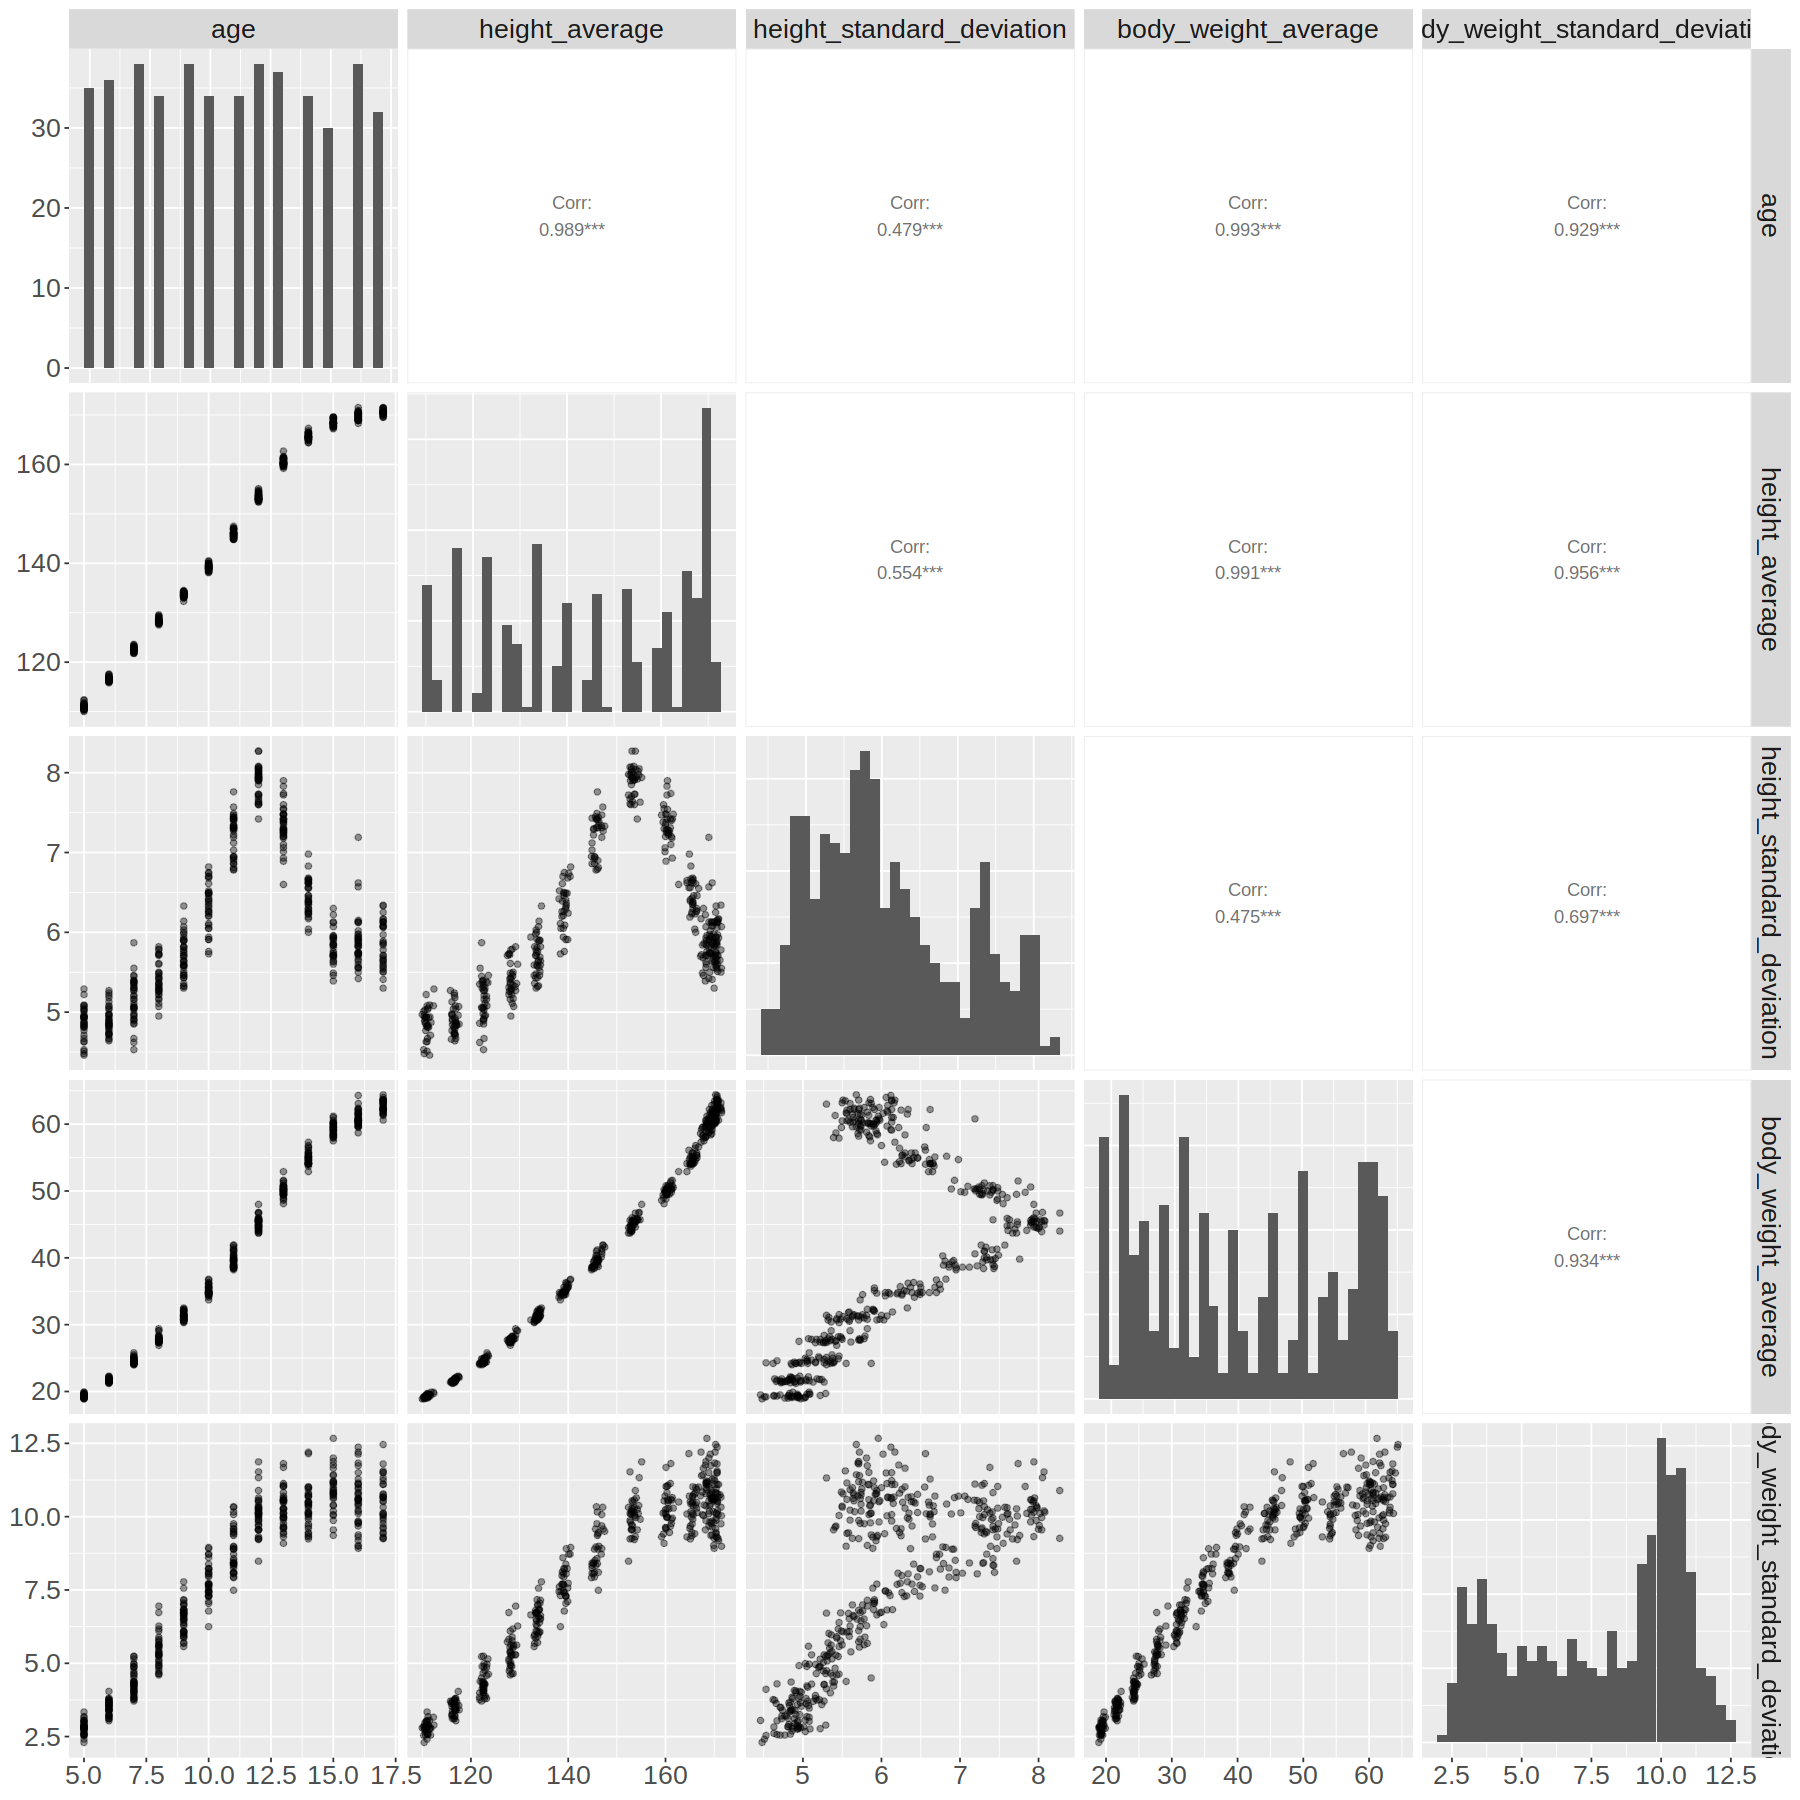

In [20]:
man_pairplot

From the pairplot above, we made our decision of **predictors selection and analysis method** based on the observation below:
1. There appear to be **strong positive linear relationships** between the target variable `age` and potential predictors `height_average`($corr = 0.989$), `weight_average`($corr = 0.993$), and `weight_standard_deviation`($corr = 0.929$) and a **weak to moderate linear relationship** between `age` and `height_standard_deviation`($corr = 0.479$). Moreover, the scatter plots between `age` and these 3 potential predictors also shows a strong evidence for **strong linear relationship** you can see that from the first column, all scatter plots demonstrated clear linear relationship except the 2nd row which is between `age` and the variable with lower correlation `height_standard_deviation` . 
    
    $\rightarrow$The high **linear** relationships between some of the potential predictors and the target variables demonstrated that **linear regression** would be a suitable model to use for predicting `age` and the variables that have high linear relationship with the target variable `age` should be considered predictors.

2. However if you look at the left corner scatter plot, which represents the relationship between the potential predictor `weight_standard_deviation` and target variable `age`, although it has a strong positive relationship with `age`, the scatter plot has shown that **the variance of the data points seems to increase when `weight_standard_deviation` increase, which violates the assumption of heteroscedasticity of variance**. This could lead to **problematic prediction error** because the regression model may predicts data with certain ranges of `weight_standard_deviation` more accurately than others. So we decided to not use this predictors `weight_standard_deviation` and remove the column.

In [24]:
# remove the columns height_standard_deviation and weight_standard_deviation 
final_data <- predictor_selection_1  |>
            select(-height_standard_deviation) 
                   